In [1]:
%run Munge_Tools.ipynb
print #---------------------------------------------------------------------
%run physiochem_graph_funct_weights_version.ipynb
%matplotlib inline
import datetime
import time
HXB2toALIGNdict = pickle.load(open("HXB2toALIGNdict.p", "rb" ) )
AlignedGagDic= pickle.load(open("AlignedGagDic.p", "rb" ) )
#AUGMENT CONSERVED POSITIONS
for tkey in seqsubdict.keys():
    augment_pos_by_all_aa(tkey) #adds 20 amino acid samples to all positions
    

function: write_tuples(filename,neworappend,header,tuples)
function: mytups,mydict=csv_to_dict(filenm)
function: mydiccol=TupEnt_to_DictCol(filt_tups,header):
function: mytuprows=DictCol_to_TupEnt(TheDict,YourHeader)



In [2]:
AlignedGagDic

{'p17': (0, 190), 'p24': (190, 460), 'p6': (580, 683), 'p7': (484, 559)}

In [3]:
aset=[(ak,HXB2toALIGNdict[ak][0],HXB2toALIGNdict[ak][1]) for ak in HXB2toALIGNdict.keys()]

In [4]:
write_tuples("HXB2AlignmentMap.csv","w",("hxb2","consensus","alignment"),aset)

In [5]:
grant_dist_weights=[0.947, 0.0526, 0.000206] #alpha,beta,gamma


## 0. Pick polyprotein to optimize

In [6]:
pn='p17'

In [7]:
if pn==None:
    p_start=seqsubdict.keys()[0]
    p_end=seqsubdict.keys()[-1]+1
else:
    sub_protein_dic = {pos_key: seqsubdict[pos_key] for pos_key in range(AlignedGagDic[pn][0]+1,AlignedGagDic[pn][1]+1)}
    seqsubdict=copy.deepcopy(sub_protein_dic)
    p_start=AlignedGagDic[pn][0]+1
    p_end=AlignedGagDic[pn][1]+1
#con_sub_protein=['-' if len(sub_protein_dic[key])<1 else f_max_aa(sub_protein_dic[key]) for key in sort(np.array(seqsubdict.keys(),dtype='f'))]

## 1. Optimization 

In [8]:
#options
global fit_amino_acid_status
fit_amino_acid_status=False
time_past=datetime.datetime.now()
protein_length=len(seqsubdict.keys())
mp=float(time_past.strftime('%M'))

In [9]:
global weights_used_in_opt
weights_used_in_opt=[]

In [10]:
def Optim_Weights(init_val):
    
    weights_used_in_opt.append(init_val)
    
    #Initialize lists and variables
        

    global fit_info_aa
    global fit_info_aa_opt
    

    fit_info_aa=[]
    log_lik_vals=[]
    
    #^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    #^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^   
    #LIKELIHOOD FUNCTION: LIKELIHOOD OF G GIVEN THE DIVERSITY OF AMINO ACIDS 
    def vpfunct(G):
        #c=consensusMapAll[subtype][pos]
        vpdist=[new_grantham_matrix[ai][c] for ai in vpa]
        vpdistall=[new_grantham_matrix[ai][c] for ai in aalist]
        #calculate individual frequency for sampled amino acids 
        #---------------------------------------------------------------------------
        vpcost=-G*np.array(vpdist)
        vpfit=np.exp(vpcost)
        #calculate total frequency for all amino acids 
        #-------------------------------------------------------------------------
        vpcostd=-G*np.array(vpdistall) #calculate distance sensitivity exponent for wij
        vpfitd=np.exp(vpcostd) #exponentiate get wij
        vpdenom=vpfitd.sum()   #sum wij
        #calculate p
        vp=[f/vpdenom for f in vpfit] #normalize each sampled wij by all wij
        return vp
    
    #OPTIMIZATION FUNCTION: FOR EVERY G CALCULATES LIKELIHOOD
    def OptimG(g):
        #Calculate your probabilities using the grantham distance of the amino acid and g
        vp=vpfunct(g)
        #Calculate the likelihood of observing th.e data given the probabilities we just calculated
        loglik=logmultinomial(vx, vp)
        return -loglik # it is a minimization function so we need to add a minus   

    #^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    #^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    
   
    # 1. Generate New Distance Matrix from Parms
    #=======================================================================================================
    alpha_weight_parm,beta_weight_parm=init_val
    this_runs_weights=weight_gen(alpha_weight_parm,beta_weight_parm)
    generator_updates_grantham=[recalc_grantham_mat_entry(aam,aan,this_runs_weights) for aam in aalist for aan in aalist]
    
   
    # 2. Run Optimization Loop for G values
    #===================================================================================
    #***********************************************************************************
    #new_grantham_matrix=copy.deepcopy(grandist)
    
    for i in range(p_start,p_end): 
        pos=i
        vpa=seqsubdict[pos].keys() #the amino acids that have particular properties
        vx=seqsubdict[pos].values() # the number of amino acids drawn for each
        upperbound=10000
        #If more than one position sampled try to estimate G
        
        if consensusMapAll[subtype][pos]=='-': #mark as gapped
            fit_info_aa.append((pos,-2,-1,'X'))
            continue
            
        if len(vx)<2 : #mark as conserved
            fit_info_aa.append((pos,-1000,-1,'X'))
            continue
        
        if sum(vx)<100: #mark as to few positions
            fit_info_aa.append((pos,-888,-1,'X'))
            continue 
        
        else: #can fit a g value  
            
            if fit_amino_acid_status==True:
                ls_put_opt_aa=aalist
            else:
                ls_put_opt_aa=list(consensusMapAll[subtype][pos])
            
            
            #PUTATIVE OPTIMAL AMINO ACID LOOP -------------------------------------------------------
            for put_opt_aa in ls_put_opt_aa:
                c=str(put_opt_aa)
               
                #INIT COND G LOOP ............................................................................
                random_gvals=[0.0001,0.001,0.01,0.1,1,10,50,75,100,120]
                current_fit_Lik=1000000000
                for start_search in random_gvals:
                    res2=optimize.minimize(OptimG,start_search,method='SLSQP',bounds=[(0.00001,upperbound)],tol=0.00001,options={'maxiter':1e10,'ftol': 1e-16})
                    if res2.fun<current_fit_Lik:
                        current_fit_Lik=float(res2.fun)
                        current_fit_obj=copy.deepcopy(res2)   
                #.............................................................................................
                fit_info_aa.append((pos,float(current_fit_obj.x),float(current_fit_obj.fun),c))
                
    #=====================================================================================================
    #*****************************************************************************************************
    
    fit_info_aa_opt=find_opt_aa(fit_info_aa)
    log_lik_vals=[el[2] for el in fit_info_aa_opt]
    #the higher the probability the smaller this value is (want to minimize)
    
    return(sum(log_lik_vals)) 

In [11]:
new_grantham_matrix=copy.deepcopy(grandist)

In [12]:
#tryansw=optimize.minimize(Optim_Weights,[0.92,0.0527],method='COBYLA',bounds=[(0.00001,0.98),(0.00001,0.98)],tol=0.0000001,options={'maxiter':10,'ftol': 1e-16})
tryansw=optimize.minimize(Optim_Weights,[ 0.77328882,  0.99810357],method='COBYLA',tol=1e-6,options={'maxiter': 2.00,'rhobeg': 0.001})

In [13]:
print tryansw
time_now=datetime.datetime.now()
print "Run Time:",float(time_now.strftime('%M'))-float(time_past.strftime('%M'))

     fun: 42106.286452970824
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 2
  status: 2
 success: False
       x: array([ 0.77428882,  0.99810357])
Run Time: 0.0


### Initial Info about Fit

In [14]:
fit_info=[s[0:3] for s in fit_info_aa_opt] #leave the amino acid off
ls_aa_mismatch=mismatch(fit_info_aa_opt) #checks to see where mismatches are

In [15]:
print ls_aa_mismatch

None


## 2. Fit Diagnostic

In [16]:
the_opt_object=copy.deepcopy(tryansw)
my_fit_info=copy.deepcopy(fit_info)
unique_key_graphs=datetime.datetime.now().strftime("%B-%d-%H-%M")
#the_header=("pos0","gval","LL")
#write_tuples("my_fit_info"+unique_key_graphs+".csv",'w',the_header,my_fit_info)

DISTANCE WEIGHT FITS
     fun: 42106.286452970824
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 2
  status: 2
 success: False
       x: array([ 0.77428882,  0.99810357])
      
grantham weights
--------------------------------------------
 alpha:  0.947  beta:  0.0526  gamma:  0.000206
 
our estimated weights
---------------------------------------------
 alpha:  0.77428882  beta:  0.225283134547  gamma:  0.000428045453087
 
ANALYSIS OF POSITIONS
total pos: 190
the number of gaps: 35
the number of conserved pos 0
the number of pos with too few samples 0
the number of fit pos 155
         
ANALYSIS OF FIT G-VALUES
[4.710424525771321, 6.166169313254741, 4.373855041930606, 6.286496081609076, 4.710294806954413, 2.7798805678872536, 8.688269479277206, 4.415622885989008, 4.189355591689844, 0.9653726876861669, 4.348402002681286, 9.341004551679399, 4.169494946275568, 1.2034878947496033, 4.455381689894079, 5.248222909462524, 3.307958540812, 10.2183

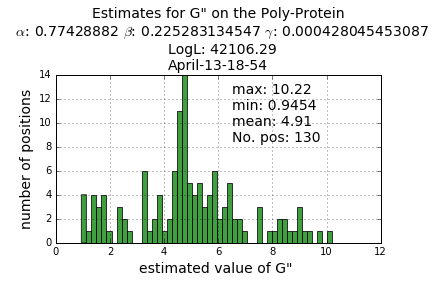

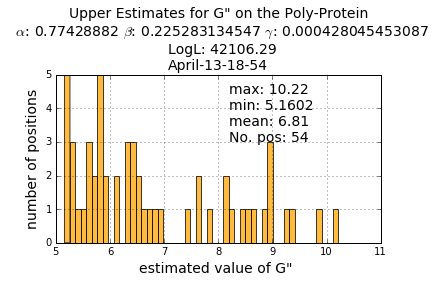

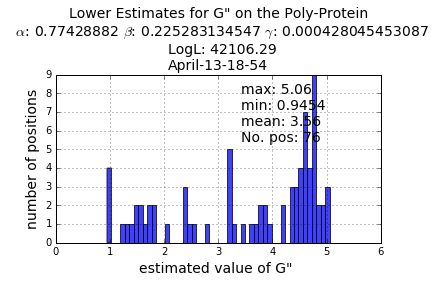

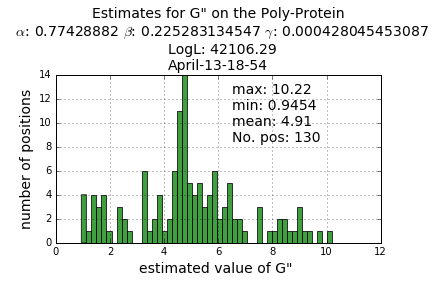

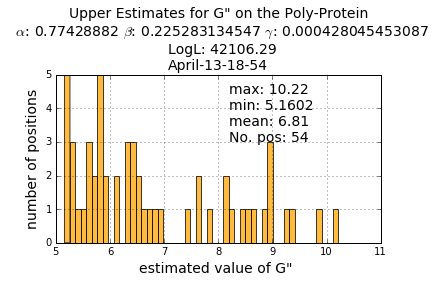

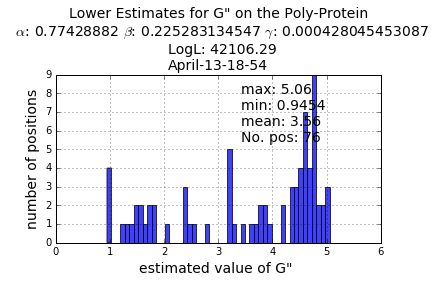

In [17]:
Fit_Diagnostic(the_opt_object=copy.deepcopy(tryansw),my_fit_info=copy.deepcopy(fit_info),unique_key_graphs=datetime.datetime.now().strftime("%B-%d-%H-%M"))

## 3. GENERATE CONFIDENCE INTERVALS

### FUNCTIONS ========================================================================

In [18]:
def vpfunct(G,vp_pos,vp_grantham_matrix,vp_amino_acid_div,vp_consensus):
    c=vp_consensus
    vpdist=[vp_grantham_matrix[ai][c] for ai in vp_amino_acid_div]
    vpdistall=[vp_grantham_matrix[ai][c] for ai in aalist]
    
    #calculate individual fitness for sampled amino acids 
    #---------------------------------------------------------------------------
    vpcost=-G*np.array(vpdist)
    vpfit=np.exp(vpcost)
    
    #calculate total frequency for all amino acids 
    #-------------------------------------------------------------------------
    vpcostd=-G*np.array(vpdistall) #calculate distance sensitivity exponent for wij
    vpfitd=np.exp(vpcostd) #exponentiate get wij
    vpdenom=vpfitd.sum()   #sum wij
    #calculate p
    vp=[f/vpdenom for f in vpfit] #normalize each sampled wij by all wij
    return vp

In [19]:
#OPTIMIZATION FUNCTION: FOR EVERY G CALCULATES LIKELIHOOD
def OptimG_Graph(g,amino_acid_num,vp_pos,vp_grantham_matrix,vp_amino_acid_div,vp_consensus):
    #Calculate your probabilities using the grantham distance of the amino acid and g
    vp=vpfunct(g,vp_pos,vp_grantham_matrix,amino_acid_div,vp_consensus)
    #Calculate the likelihood of observing th.e data given the probabilities we just calculated
    loglik=logmultinomial(amino_acid_num, vp)
    return -loglik # we are graphing this so no minus

In [20]:
def LL_surface_with_new_consensus(new_consensus,minval,maxval):
    outputs=[(OptimG_Graph(i,amino_acid_num,pos,new_grantham_matrix,amino_acid_div,new_consensus),i) for i in np.arange(minval,maxval,0.10)]
    return zip(*outputs)
       

### ====================================================================================================

### 3A. make grantham matrix for fit parameters

In [21]:
new_grantham_matrix=copy.deepcopy(grandist)

# 1. Generate New Distance Matrix from Parms
#=======================================================================================================
alpha_weight_parm,beta_weight_parm=list(tryansw.x)
this_runs_weights=weight_gen(alpha_weight_parm,beta_weight_parm)
generator_updates_grantham=[recalc_grantham_mat_entry(aam,aan,this_runs_weights) for aam in aalist for aan in aalist]
#this_runs_weights=grant_dist_weights
weight_string="alpha: {:0.3g} beta: {:0.3g} gamma: {:0.3g}".format(this_runs_weights[0],this_runs_weights[1],this_runs_weights[2])

### 3B. Loop: Get CI per position

In [22]:
fit_info_ci=[]

In [23]:
minsub=0.0
maxsub=max([p[1] for p in fit_info])+100
mymin=0.0
mymax=max([p[1] for p in fit_info])+100


Cpos,Cag,CLL=zip(*fit_info)
fit_info_ci=[]

for i,pos in enumerate(Cpos):
    #print i
    #-----------------------------------------------------------------------------
    if fit_info[i][1] in [-1000,-2,-888,1000]:
        new_fit_info_entry=list(fit_info[i])+[-1,-1]
        fit_info_ci.append(new_fit_info_entry)
        continue
    #-----------------------------------------------------------------------------------
    
    # 1. pull off info about position
    amino_acid_div=seqsubdict[pos].keys() #the amino acids that have particular properties
    amino_acid_num=seqsubdict[pos].values() # the number of amino acids drawn for each
    # 2. plot area around position
    aa1=consensusMapAll["C"][pos]
    lv1,gv1=LL_surface_with_new_consensus(aa1,Cag[i]-0.90*Cag[i],Cag[i]+1.5*Cag[i])
    # 3. find CI around G
    lwci,upci=CI_G(pos,np.array(lv1),np.array(gv1))
    #print lwci,upci
    # 4. Add to fits
    #print lwci,fit_info[pos][1],upci
    new_fit_info_entry=list(fit_info[i])+[lwci,upci]
    fit_info_ci.append(new_fit_info_entry)

gval_ci: plot confidence interval distance
outlier: find gval_ci with large confidence intervals

In [24]:
gval_ci=[(e[0],e[1],e[4]-e[3]) for e in fit_info_ci if e[3]!=-1 ]


In [25]:
outlier=sorted(gval_ci, key=lambda x:x[2])
#print outlier[-8:-1]

## 3.C Graphing

Code below to look at a specific postions

In [26]:
# print "====="*10
# print "set amino acids",seqsubdict[o_pos]
# print "consensus:",consensusMapAll["C"][o_pos]
# look_up_pos=filter(lambda x:x[0]==o_pos,fit_info_ci)[0]
# col_names=['position','g-value','likelihood','lower CI','upper CI']
# for myset in zip(col_names,look_up_pos):
#     print myset

In [27]:
pos,myg,myci=zip(*gval_ci)

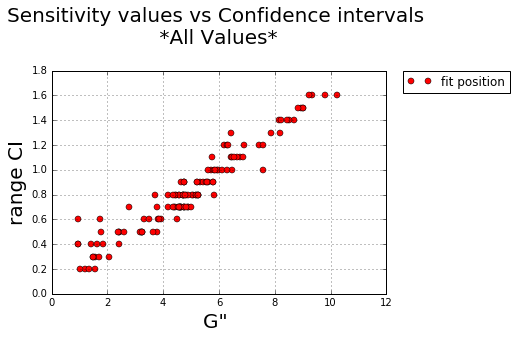

In [28]:
plt.plot(myg,myci,'ro',lw=3,label="fit position")
plt.title("Sensitivity values vs Confidence intervals \n *All Values* \n",fontsize=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel("range CI",fontsize=20)
plt.xlabel("G\" ",fontsize=20)
plt.grid(True)

## 4. Write Simulation Results: pos,gval,-LL,upci,lwci

In [60]:
tup_pos_shan=[] #shannon values
pos_start,pos_end=(fit_info_ci[0][0],fit_info_ci[-1][0]) #the range of positions we estimated for
tup_pos_shan_subset=tup_pos_shan[pos_start:pos_end]
save_info=[tuple(list(al)+list(el)) for el,al in zip(tup_pos_shan_subset,fit_info_ci)]

In [ ]:
unique_key_graphs

In [ ]:
#write the amino acid fits
the_header=["pos","gval","ll","aa"]
#write_tuples("aa_data_frame_LL_68356_"+unique_key_graphs+".csv","w",the_header,fit_info_aa)

#write the optimal amino acid fits
the_header=["pos","gval","ll","lwci","upci","shanpos","shannon_val"]
write_tuples("gvalue_data_frame_LL_Test_"+unique_key_graphs+"p17"+".csv","w",the_header,save_info)


# EXTRA ANALYSIS

## 5. Plot Optimizations with CI

In [ ]:
# 1. pull off info about position
amino_acid_div=seqsubdict[pos].keys() #the amino acids that have particular properties
amino_acid_num=seqsubdict[pos].values() # the number of amino acids drawn for each

In [ ]:
def plot_LL_surface(gv,lv,aa="NA",num=1): #depends on Create_CI
    pltline={1:'b-.',2:'g--',3:'r'}
    vrtline={1:'b',2:'g',3:'r'}
    min1=min(zip(gv,lv),key=lambda x:x[1])[0]
    the_label="Opt.AA:"+aa+'\n G\" = '+str("%.6f" %  min1)
    plt.plot(gv,lv,pltline[num],lw=3,label=the_label)
    plt.axvline(x=min1,color=vrtline[num])
    lwci,upci=Create_CI(gv,lv)
    plt.axvspan(lwci,upci, alpha=0.10, color=vrtline[num])

In [ ]:
#graph
mymin=20.0
mymax=120
#calculate
minsub=20.0
maxsub=120
aa1=consensusMapAll["C"][pos]
aa2=aa1
lv1,gv1=LL_surface_with_new_consensus(aa1,minsub,maxsub)
lv2,gv2=LL_surface_with_new_consensus(aa2,minsub,maxsub)

In [ ]:
min(zip(lv1,gv1),key=lambda x:x[0])

In [ ]:
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker
fig = plt.figure()
plot_LL_surface(gv1,lv1,aa=aa1,num=1)
plot_LL_surface(gv2,lv2,aa=aa2,num=2)

plt.xlim(xmin=mymin,xmax=mymax)
plt.xlabel('G" ',fontsize=16) 
plt.ylabel('-LL',fontsize=16)


Subtitle="Grantham Weights from Optimization"
Title_str="-LogLik surface for G\": pos("+str(pos)+")" +"\n"+Subtitle

plt.title(Title_str+"\n"+weight_string+"\n"+str(seqsubdict[pos]),fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#txt = str(seqsubdict[pos])
#plt.text(0.1,0.2,txt,fontsize=14)

### Fill in Gaps in fit_info_ci

In [ ]:
posci=[line[0] in fit_info_ci

In [ ]:
posci

In [ ]:
fit_info_ci_tuple=[tuple(a_pos) for a_pos in fit_info_ci]

In [ ]:
the_header=["pos","gval","ll","lwci","upci"]

In [ ]:
write_tuples("gvalue_data_frame.csv","w",the_header,fit_info_ci_tuple)
